In [184]:
import numpy as np 
import torch 
import pandas as pd
import yfinance as yf
from arch import arch_model
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl


In [185]:
def generate_ground_garch(omega, alpha, beta, n=1000):
    
    am = arch_model(None, mean='Zero', vol='GARCH', p=1, q=1, power = 2) #Остатки просто получаются умножением волатильности на кси ~N(0,1)
    params = np.array([omega, alpha, beta])
    am_data = am.simulate(params, n)
#ВОЗВРАЩАЕТ ЛОГДОХОДНОСТИ!!!!
    return (am_data['data'].to_numpy()/am_data['volatility'].to_numpy()), am_data['volatility'].to_numpy()

In [186]:
omega, alpha, beta = 0.2, 0.2, 0.3

In [187]:
class CustomSyntDataset(Dataset):

    def __init__(self, omega, alpha, beta, n =1000):
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.n = n
        self.residuals, self.volatility = generate_ground_garch(omega, alpha, beta, n)

        self.inputs = np.column_stack([
            np.full_like(self.residuals, 1),
            np.square(self.residuals),
            np.square(self.volatility)
        ])
        
        self.outputs = np.square(np.roll(self.volatility, -1))

        self.inputs = torch.Tensor(self.inputs)

        self.outputs = torch.Tensor(self.outputs)

    def __len__(self):
        return self.n -1 
    
    def __getitem__(self, index):
        return self.inputs[index], self.outputs[index], self.inputs[index+1, 1]

In [203]:
normdist, voll = generate_ground_garch(omega, alpha, beta)

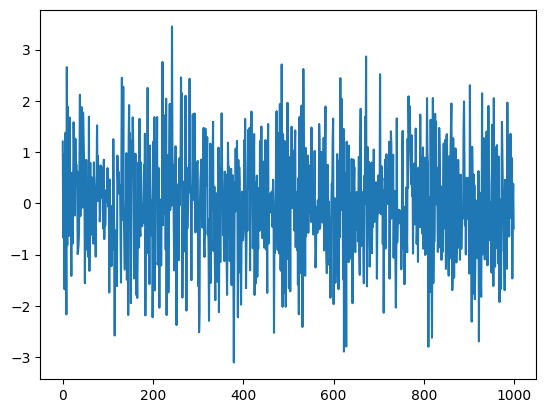

In [189]:
plt.plot(np.arange(1000), np.random.standard_normal(1000))

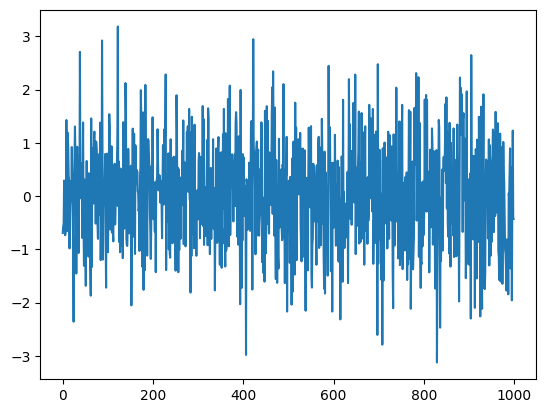

In [190]:
plt.plot(np.arange(1000), normdist)



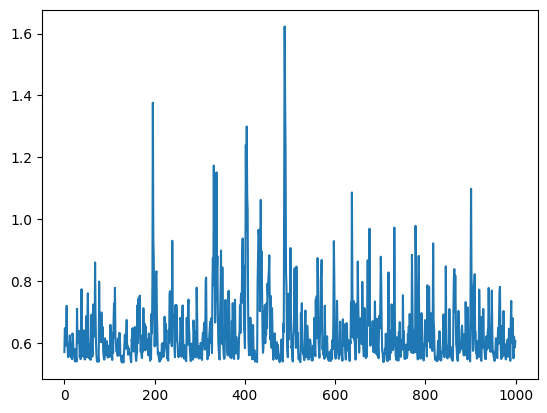

In [204]:
plt.plot(np.arange(1000), voll)

In [191]:
ds = CustomSyntDataset(omega=omega, alpha=alpha, beta = beta)

In [192]:
for i in range(1, 5):
    print(ds[i])

(tensor([1.0000, 0.4515, 0.5368]), tensor(0.4095), tensor(1.2685))
(tensor([1.0000, 1.2685, 0.4095]), tensor(0.4268), tensor(0.9469))
(tensor([1.0000, 0.9469, 0.4268]), tensor(0.4088), tensor(0.1490))
(tensor([1.0000, 0.1490, 0.4088]), tensor(0.3348), tensor(0.0124))


In [193]:
dl = DataLoader(ds, batch_size = 64, shuffle= False, drop_last=True)

In [194]:
class GarchNN(torch.nn.Module):
    def __init__(self):
        super(GarchNN, self).__init__()
        self.model =nn.Sequential(
            nn.Flatten(),
            nn.Linear(3,1, bias=False)
        )

    def forward (self, x):
        return self.model(x).squeeze(-1)

In [195]:
class NLoss(torch.nn.Module):
    def __init__(self):
        super(NLoss, self).__init__()

    def forward(self, pred_volatility, target_resid):
        left_side = torch.log(pred_volatility)/2
        right_side = (target_resid/pred_volatility) /2

        return (left_side + right_side).sum()
                

In [196]:
model = GarchNN()
optimizer = torch.optim.Adam(model.parameters(), lr =1e-3)
#criterion = NLoss()
criterion = nn.MSELoss()

In [197]:
num_epochs = 500

for epochs in tqdm(range(num_epochs), desc="Training"):
    epoch_loss =0.0
    model.train()

    for inputs, targets, resids in dl:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()

    avg_loss = epoch_loss/len(dl)

    tqdm.write(f"Epoch {epochs+1}/{num_epochs} | Loss: {avg_loss:.4f}")
    

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500 | Loss: 0.1526
Epoch 2/500 | Loss: 0.1328
Epoch 3/500 | Loss: 0.1164
Epoch 4/500 | Loss: 0.1031
Epoch 5/500 | Loss: 0.0921
Epoch 6/500 | Loss: 0.0827
Epoch 7/500 | Loss: 0.0742
Epoch 8/500 | Loss: 0.0666
Epoch 9/500 | Loss: 0.0595
Epoch 10/500 | Loss: 0.0531
Epoch 11/500 | Loss: 0.0472
Epoch 12/500 | Loss: 0.0418
Epoch 13/500 | Loss: 0.0370
Epoch 14/500 | Loss: 0.0326
Epoch 15/500 | Loss: 0.0287
Epoch 16/500 | Loss: 0.0252
Epoch 17/500 | Loss: 0.0221
Epoch 18/500 | Loss: 0.0194
Epoch 19/500 | Loss: 0.0169
Epoch 20/500 | Loss: 0.0148
Epoch 21/500 | Loss: 0.0130
Epoch 22/500 | Loss: 0.0114
Epoch 23/500 | Loss: 0.0100
Epoch 24/500 | Loss: 0.0088
Epoch 25/500 | Loss: 0.0077
Epoch 26/500 | Loss: 0.0068
Epoch 27/500 | Loss: 0.0061
Epoch 28/500 | Loss: 0.0054
Epoch 29/500 | Loss: 0.0049
Epoch 30/500 | Loss: 0.0044
Epoch 31/500 | Loss: 0.0040
Epoch 32/500 | Loss: 0.0037
Epoch 33/500 | Loss: 0.0034
Epoch 34/500 | Loss: 0.0032
Epoch 35/500 | Loss: 0.0030
Epoch 36/500 | Loss: 0.0028
E

In [198]:
print(torch.isnan(ds.inputs).any(), torch.isinf(ds.inputs).any())
print(torch.isnan(ds.outputs).any(), torch.isinf(ds.outputs).any())

tensor(False) tensor(False)
tensor(False) tensor(False)


In [199]:
def get_model_weights(model):
    weights = {}
    for name, param in model.named_parameters():
        weights[name] = param.data.clone().cpu().numpy()
    return weights

model_weights = get_model_weights(model)

In [200]:
model_weights

{'model.1.weight': array([[0.11727517, 0.08250016, 0.498137  ]], dtype=float32)}

In [201]:
test_variance = np.random.standard_normal()

In [202]:
test_cases = [
    # pred_vol, target_resid (все значения > 1)
    (torch.tensor([58]), torch.tensor([1])),
    (torch.tensor([180]), torch.tensor([145])),
    (torch.tensor([300]), torch.tensor([290])),

]

criterion = NLoss()

print("Тестирование NLoss для значений > 1:\n")
print("| pred_vol | target_resid | log(pred)/2 | resid/(2*pred) | total_loss |")
print("|----------|--------------|-------------|----------------|------------|")

for pred, target in test_cases:
    log_term = 0.5 * torch.log(pred)
    ratio_term = target / (2 * pred)
    loss = criterion(pred, target)
    
    print(f"| {pred.item():>8.2f} | {target.item():>12.2f} | {log_term.item():>11.4f} | {ratio_term.item():>14.4f} | {loss.item():>10.4f} |")

Тестирование NLoss для значений > 1:

| pred_vol | target_resid | log(pred)/2 | resid/(2*pred) | total_loss |
|----------|--------------|-------------|----------------|------------|
|    58.00 |         1.00 |      2.0302 |         0.0086 |     2.0388 |
|   180.00 |       145.00 |      2.5965 |         0.4028 |     2.9993 |
|   300.00 |       290.00 |      2.8519 |         0.4833 |     3.3352 |
